### EDA

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as pltds

Loading dataset we'll be training with:

In [2]:
train = pd.read_csv('data/train.csv.zip')

In [3]:
train.shape #4167 rows & 74 columns

(4167, 74)

As it's quite large, let's tweak pd options to dive into our dataset comfortably. This way we can display columns/rows desired with no kind of restriction.

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

 ## Looking @ our target

In [5]:
train['price'].describe()

count    4167.000000
mean      168.676986
std       180.658555
min         0.000000
25%        98.000000
50%       138.000000
75%       200.000000
max      6477.000000
Name: price, dtype: float64

In [6]:
train['price'].max(),train['price'].min() # FREE acomodations!! yay!! - probably scrape error

(6477.0, 0.0)

In [7]:
train[train['price'] == 0] #4 free acomodations

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
190,190,https://www.airbnb.com/rooms/42431450,20211205213126,2021-12-05,Melrose Hotel,NaN,NaN,https://a0.muscache.com/pictures/92796479-d704...,311321908,https://www.airbnb.com/users/show/311321908,Melrose Hotel,2019-11-22,NL,NaN,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/5e591...,https://a0.muscache.com/im/pictures/user/5e591...,NaN,9,9,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,NaN,Centrum-West,NaN,52.369640,4.880040,Room in hotel,Hotel room,4,NaN,NaN,NaN,NaN,"[""Air conditioning"", ""Bed sheets and pillows"",...",0.0,1,365,1.0,1.0,365.0,365.0,1.0,365.0,NaN,t,0,0,0,0,2021-12-05,6,5,0,2020-11-16,2021-10-22,4.17,4.17,4.33,4.67,4.33,4.83,3.83,NaN,f,4,0,3,0,0.47
437,437,https://www.airbnb.com/rooms/42431273,20211205213126,2021-12-06,Hotel Abba,NaN,NaN,https://a0.muscache.com/pictures/8b8ce867-afeb...,309119467,https://www.airbnb.com/users/show/309119467,Hotel Abba,2019-11-13,NL,NaN,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/5b13d...,https://a0.muscache.com/im/pictures/user/5b13d...,Oud-West,6,6,"['email', 'phone']",t,t,NaN,De Baarsjes - Oud-West,NaN,52.362790,4.874580,Room in hotel,Hotel room,3,NaN,NaN,NaN,NaN,"[""Bed sheets and pillows"", ""Luggage dropoff al...",0.0,1,365,1.0,1.0,1125.0,1125.0,1.0,1125.0,NaN,t,0,0,0,0,2021-12-06,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,0,0,NaN
1763,1763,https://www.airbnb.com/rooms/47110768,20211205213126,2021-12-05,Sir Albert,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,380676508,https://www.airbnb.com/users/show/380676508,Sircle,2020-12-18,"Amsterdam, North Holland, Netherlands",We are a collection of creative hospitality br...,NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/bdea7...,https://a0.muscache.com/im/pictures/user/bdea7...,NaN,5,5,"['email', 'phone']",t,t,NaN,De Pijp - Rivierenbuurt,NaN,52.355585,4.887072,Room in boutique hotel,Hotel room,0,NaN,NaN,NaN,NaN,"[""Air conditioning"", ""Luggage dropoff allowed""...",0.0,1,365,1.0,1.0,1125.0,1125.0,1.0,1125.0,NaN,f,0,0,0,0,2021-12-05,1,1,0,2021-01-17,2021-01-17,5.00,4.00,5.00,5.00,5.00,5.00,5.00,NaN,f,1,0,0,0,0.09
2739,2739,https://www.airbnb.com/rooms/45478851,20211205213126,2021-12-06,The Delphi - Amsterdam Townhouse,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,367980459,https://www.airbnb.com/users/show/367980459,The Delphi,2020-09-17,NL,NaN,within an hour,100%,0%,f,https://a0.muscache.com/im/pictures/user/2ed1d...,https://a0.muscache.com/im/pictures/user/2ed1d...,NaN,0,0,"['email', 'phone']",t,t,NaN,Zuid,NaN,52.350460,4.876840,Room in boutique hotel,Hotel room,0,NaN,NaN,NaN,NaN,"[""Air conditioning"", ""Hangers"", ""Iron"", ""Coffe..."

Quick histplot of prices

<AxesSubplot:>

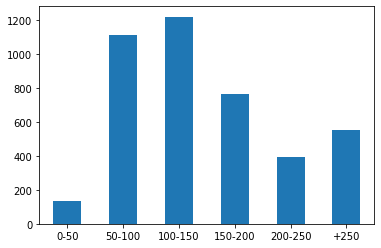

In [34]:
prices = pd.cut(train['price'],
                bins = [0, 50, 100, 150, 200, 250, train["price"].max()],
                labels=["0-50", "50-100", "100-150", "150-200", "200-250", "+250"])
 
prices.value_counts().sort_index().plot(kind="bar", rot = 0)


### LOOKING @ COLUMNS

How does our df's rows look like?
Just like <code>df.head(1)</code>, but nicer ;)

In [ ]:
train.iloc[train['id'][0]] 

In [ ]:
#train.info()

NaN values

In [ ]:
nan_rank = train.isna().sum() #Most to least Nans columns
nan_rank[nan_rank.values > 0].sort_values(ascending=False)